# Skin Lesion Classification Using Deep Learning 

## Introduction:
Skin cancer is the most common form of human malignancy, posing significant health risks worldwide. Early and accurate classification of skin lesions is crucial for effective treatment and improved patient outcomes. This project aims to assist in the classification of skin lesions by employing Convolutional Neural Networks (CNNs) to train a deep neural network. 

## Motivation and Problem Statement:
The motivation for this project is to enhance the early detection and diagnosis of skin cancer through advanced technology. 

The project aims to develop a deep learning model that can accurately classify skin lesions into distinct categories, such as melanoma, nevi, and benign lesions. 

## Data Sources:
The primary data source for this project is the 2018 International Skin Imaging Collaboration (ISIC) dataset, 
which contains a diverse collection of dermatoscopic images annotated with ground truth labels for various skin lesion categories.
Dataset URL: https://challenge.isic-archive.com/data/#2018

## Exploratory Analysis of Data:

The ISIC 2018 dataset contains a diverse collection of dermatoscopic images, each annotated with one of seven distinct skin lesion categories. These categories are as follows:
-	NV (Melanocytic Nevi): Benign mole-like lesions.
-	MEL (Melanoma): Malignant skin cancer lesions.
-	BKL (Benign Keratosis-like Lesions): Non-cancerous lesions often resembling keratosis.
-	BCC (Basal Cell Carcinoma): A common form of skin cancer.
-	AKIEC (Actinic Keratoses): Pre-cancerous lesions caused by sun damage.
-	VASC (Vascular Lesions): Lesions related to blood vessels, often benign.
-	DF (Dermatofibroma): Benign fibrous nodules.

The dataset includes images categorized into the seven classes.

## CNN

### 1 : importing Essential Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import matplotlib.pyplot as plt
from PIL import Image
import glob


### 2 : Making Dictionary of images and labels &  Reading & Processing data
In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named train_data_dir, val_data_dir and test_data_dir. After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [2]:

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

train_data_dir = 'ISIC2018_Task3_Training_Input'
train_groundtruth = 'ISIC2018_Task3_Training_GroundTruth.csv'
val_data_dir = 'ISIC2018_Task3_Validation_Input'
val_groundtruth = 'ISIC2018_Task3_Validation_GroundTruth.csv'
test_data_dir = 'ISIC2018_Task3_Test_Input'
test_groundtruth = 'ISIC2018_Task3_Test_GroundTruth.csv'

train_paths = glob.glob(os.path.join(train_data_dir, '*.jpg'))
train_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in train_paths}
val_paths = glob.glob(os.path.join(val_data_dir, '*.jpg'))
val_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in val_paths}
test_paths = glob.glob(os.path.join(test_data_dir, '*.jpg'))
test_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in test_paths}

input_shape = (75, 100, 3)
num_classes = 7
batch_size = 16
epochs = 20

lesion_type_dict = {
    'NV': 'Melanocytic_nevi',
    'MEL': 'melanoma',
    'BKL': 'Benign_keratosis-like_lesions',
    'BCC': 'Basal_cell_carcinoma',
    'AKIEC': 'Actinic_keratoses',
    'VASC': 'Vascular_lesions',
    'DF': 'Dermatofibroma',
}

label_mapping = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

def classify_disease(row):
    if row['MEL'] == 1.0:
        return 'MEL'
    elif row['NV'] == 1.0:
        return 'NV'
    elif row['BCC'] == 1.0:
        return 'BCC'
    elif row['AKIEC'] == 1.0:
        return 'AKIEC'
    elif row['BKL'] == 1.0:
        return 'BKL'
    elif row['DF'] == 1.0:
        return 'DF'
    elif row['VASC'] == 1.0:
        return 'VASC'
    else:
        return 'Unknown'

train_df = pd.read_csv(train_groundtruth)
val_df = pd.read_csv(val_groundtruth)
test_df = pd.read_csv(test_groundtruth)

train_df['dx'] = train_df.apply(classify_disease, axis=1)
val_df['dx'] = val_df.apply(classify_disease, axis=1)
test_df['dx'] = test_df.apply(classify_disease, axis=1)

train_df['path'] = train_df['image'].map(train_path_dict.get)
train_df['cell_type'] = train_df['dx'].map(lesion_type_dict.get)
train_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
train_df["cell_type_idx"] = pd.Categorical(train_df["cell_type"]).codes

val_df['path'] = val_df['image'].map(val_path_dict.get)
val_df['cell_type'] = val_df['dx'].map(lesion_type_dict.get)
val_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
val_df["cell_type_idx"] = pd.Categorical(val_df["cell_type"]).codes

test_df['path'] = test_df['image'].map(test_path_dict.get)
test_df['cell_type'] = test_df['dx'].map(lesion_type_dict.get)
test_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
test_df["cell_type_idx"] = pd.Categorical(test_df["cell_type"]).codes


# In this step, we also resize the images as the original dimension of images are 450 x 600 x3 
# which TensorFlow can't handle, so that's why we resize it into 100 x 75.

train_df['image_size'] = train_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
val_df['image_size'] = val_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
test_df['image_size'] = test_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

train_df.head()

image   dx                                            path  \
0  ISIC_0024306   NV  ISIC2018_Task3_Training_Input\ISIC_0024306.jpg   
1  ISIC_0024307   NV  ISIC2018_Task3_Training_Input\ISIC_0024307.jpg   
2  ISIC_0024308   NV  ISIC2018_Task3_Training_Input\ISIC_0024308.jpg   
3  ISIC_0024309   NV  ISIC2018_Task3_Training_Input\ISIC_0024309.jpg   
4  ISIC_0024310  MEL  ISIC2018_Task3_Training_Input\ISIC_0024310.jpg   

          cell_type  cell_type_idx  \
0  Melanocytic_nevi              4   
1  Melanocytic_nevi              4   
2  Melanocytic_nevi              4   
3  Melanocytic_nevi              4   
4          melanoma              6   

                                          image_size  
0  [[[228, 131, 133], [229, 131, 137], [231, 125,...  
1  [[[216, 121, 133], [217, 121, 136], [218, 126,...  
2  [[[246, 173, 181], [246, 171, 176], [246, 170,...  
3  [[[206, 117, 133], [210, 121, 136], [211, 120,...  
4  [[[72, 33, 37], [70, 32, 38], [69, 31, 38], [6...

### 3 : EDA
In this step we will explore different features of the dataset , their distrubtions and actual counts.
Plot to see distribution of 7 different classes of cell type.

<Axes: xlabel='cell_type'>

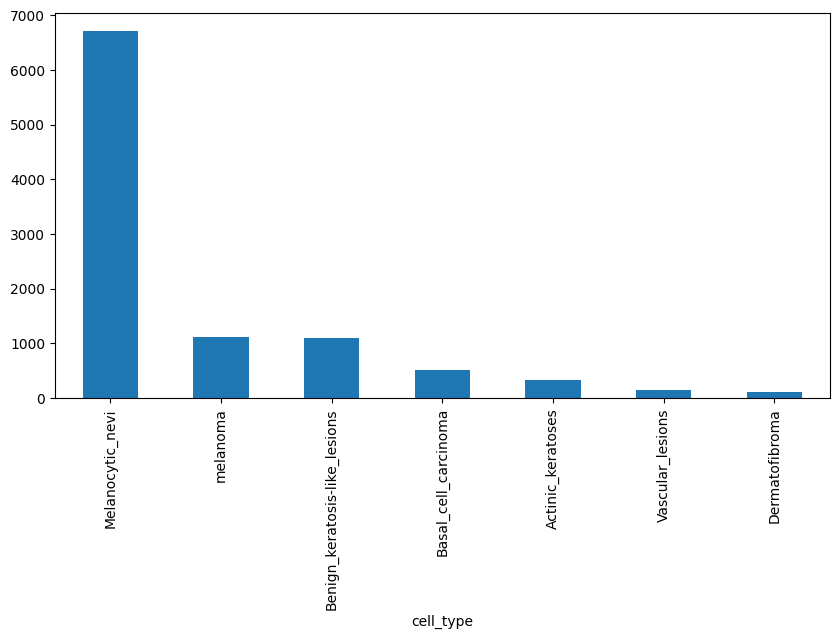

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
train_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

Sample of images Below we will show images of each cancer type

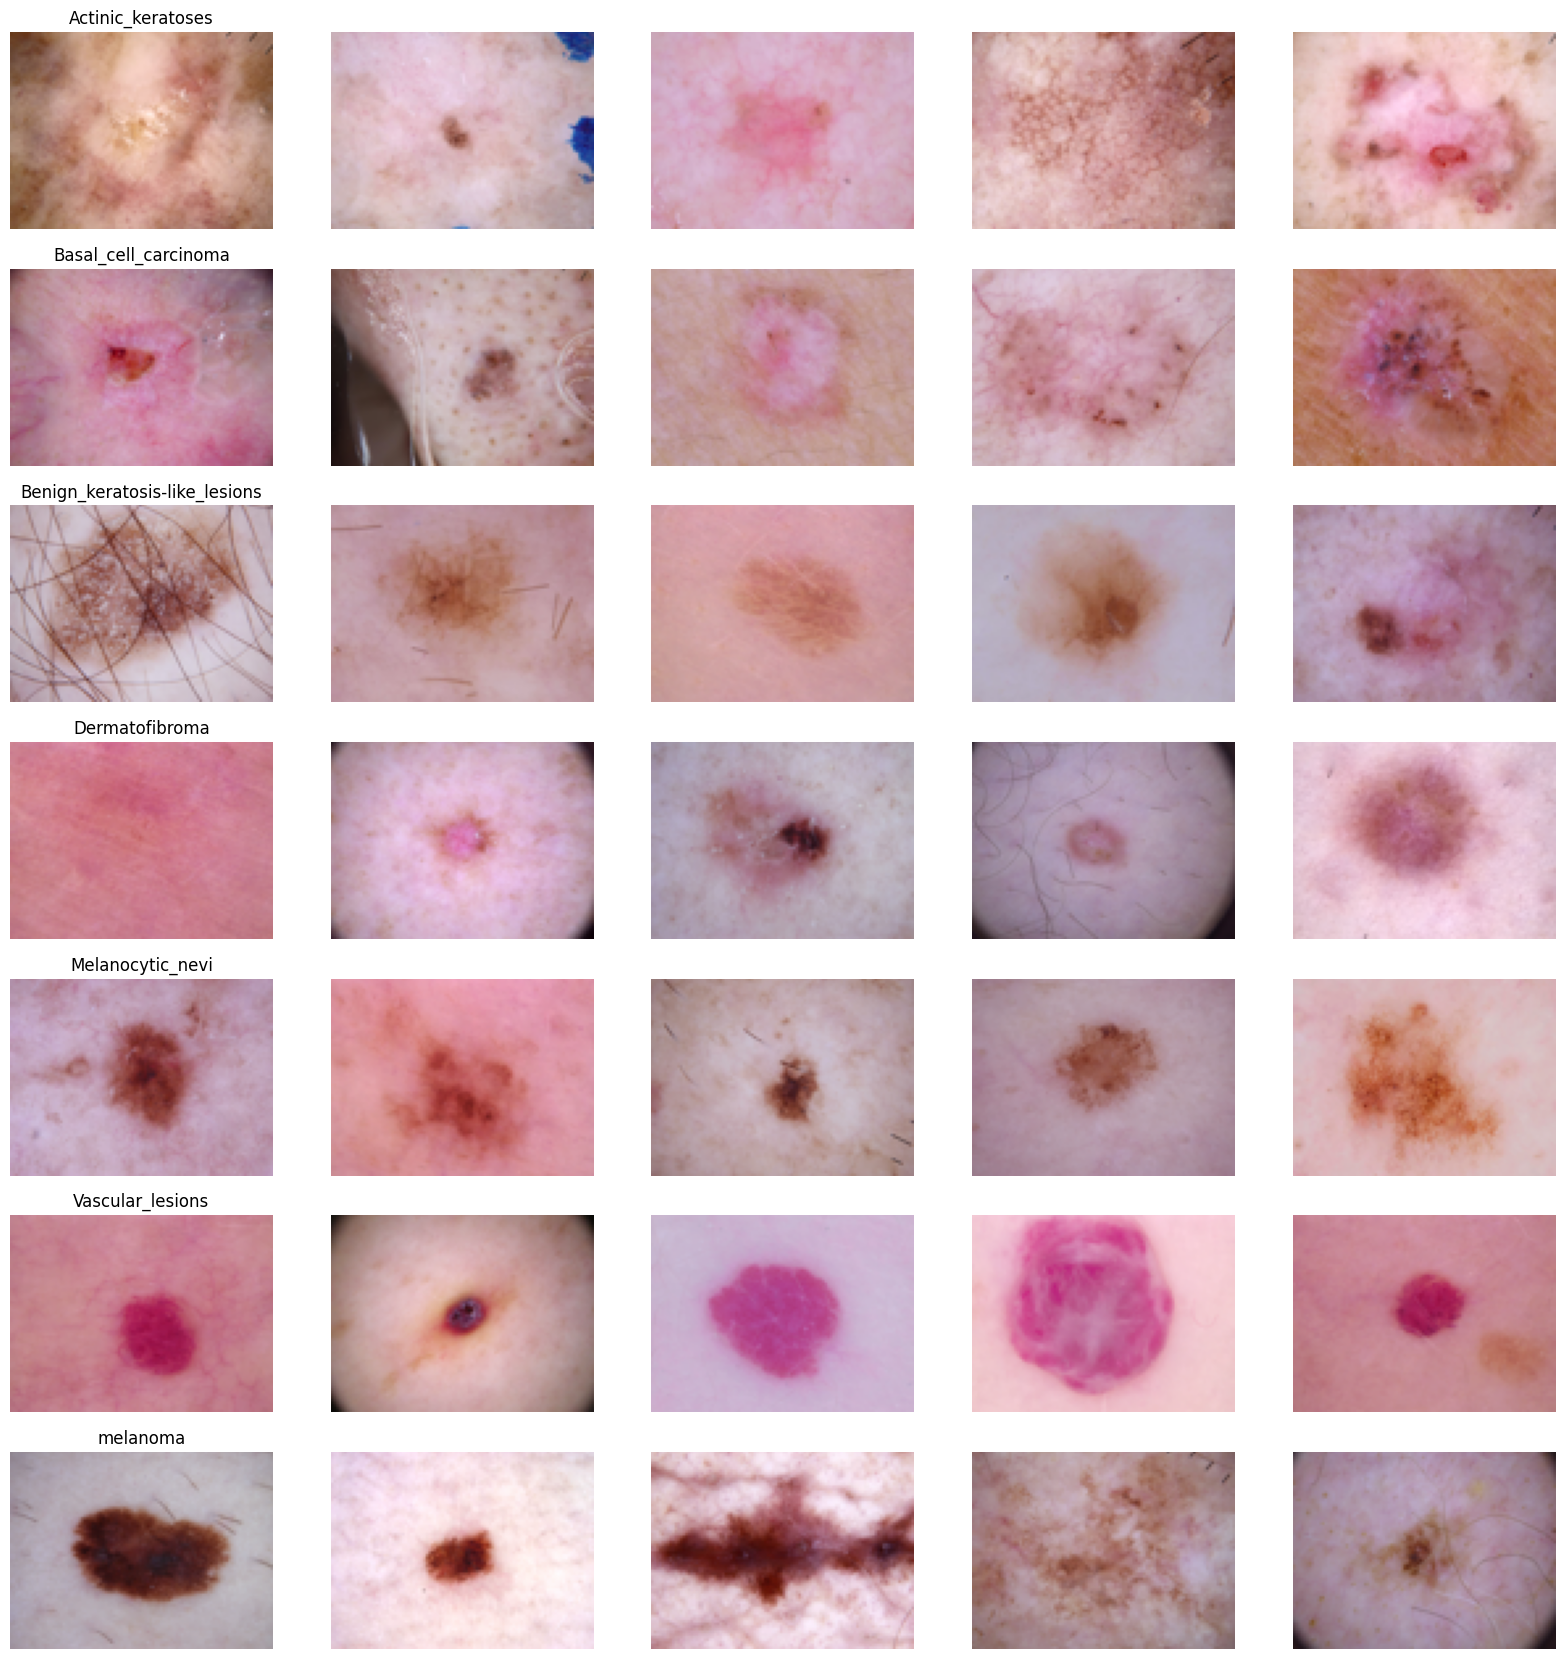

In [4]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         train_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image_size'])
        c_ax.axis('off')

### 4: Normalization
I choosed to normalize the x_train, x_test, x_val by substracting from theor mean values and then dividing by thier standard deviation.

Previous work splits the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model. But I already had train, test and validation sets to train the model.

In [9]:
x_train = np.asarray(train_df['image_size'].tolist())
x_val = np.asarray(val_df['image_size'].tolist())
x_test = np.asarray(test_df['image_size'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_val_mean = np.mean(x_val)
x_val_std = np.std(x_val)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_val_mean) / x_val_std
x_test = (x_test - x_test_mean) / x_test_std

### 5: Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [8]:
y_train = to_categorical(train_df['cell_type_idx'], num_classes=num_classes)
y_val = to_categorical(val_df['cell_type_idx'], num_classes=num_classes)
y_test = to_categorical(test_df['cell_type_idx'], num_classes=num_classes)

### 6: Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations.
- randomly rotate images in the range (degrees, 0 to 180)
- randomly zoom image
- randomly shift images horizontally (fraction of total width)
- randomly shift images vertically (fraction of total height)
- randomly flip images

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

### 7: Model Building
The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [22]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='Same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.40))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 75, 100, 32)       896       
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 37, 50, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 50, 64)        36928     
                                                      

### 8: Setting Optimizer and Annealer
Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR). The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. it is better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

In [23]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

### 9: Fitting the model
This part I create a function: create_dataset, which is my own work

The purpose of the create_dataset function is to create a TensorFlow dataset object from given input data and labels. This dataset can be efficiently used for training models. The function performs the following steps:
1.	Create a Dataset: Create a tf.data.Dataset object from the input data and labels.
2.	Shuffle the Dataset: Shuffle the dataset to avoid dependency on the order of the data during training.
3. Batch the Data: Use the batch method to split the dataset into batches of specified size, improving training efficiency.
4. Repeat the Dataset: Use the repeat method to ensure the dataset does not run out during training by repeating the dataset after each epoch.

In [24]:
def create_dataset(x, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size).repeat()
    return dataset

train_dataset = create_dataset(x_train, y_train, batch_size)
val_dataset = create_dataset(x_val, y_val, batch_size)
test_dataset = create_dataset(x_test, y_test, batch_size)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_val) // batch_size,
    callbacks=[learning_rate_reduction],
    verbose=1
)

loss_val, acc_val = model.evaluate(val_dataset, steps=len(x_val) // batch_size, verbose=1)
print(f"Validation: accuracy = {acc_val:.4f}  ;  loss = {loss_val:.4f}")

loss_test, acc_test = model.evaluate(test_dataset, steps=len(x_test) // batch_size, verbose=1)
print(f"Test: accuracy = {acc_test:.4f}  ;  loss = {loss_test:.4f}")

model.save('my_model.keras')

Epoch 1/20
625/625 [==============================] - 12s 18ms/step - loss: 1.0279 - accuracy: 0.6690 - val_loss: 0.8354 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 11s 18ms/step - loss: 0.8926 - accuracy: 0.6845 - val_loss: 0.7660 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 11s 18ms/step - loss: 0.8445 - accuracy: 0.6924 - val_loss: 0.7244 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 12s 18ms/step - loss: 0.8150 - accuracy: 0.7017 - val_loss: 0.7068 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 11s 18ms/step - loss: 0.7803 - accuracy: 0.7129 - val_loss: 0.6105 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 12s 18ms/step - loss: 0.7623 - accuracy: 0.7201 - val_loss: 0.5916 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 11s 

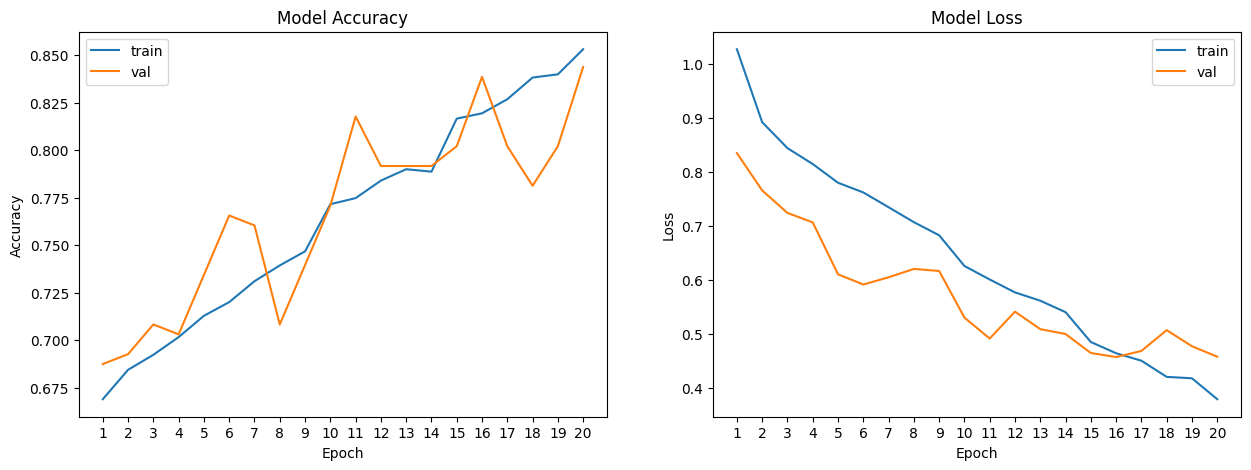

In [25]:
# Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

plot_model_history(history)

48/48 [==============================] - 1s 26ms/step


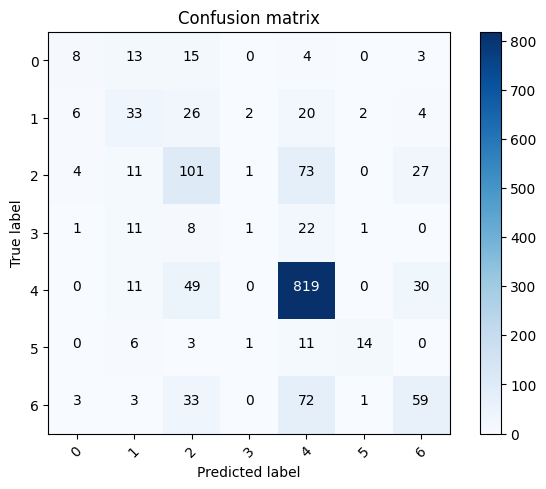

In [10]:
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
model = load_model('my_model.keras')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

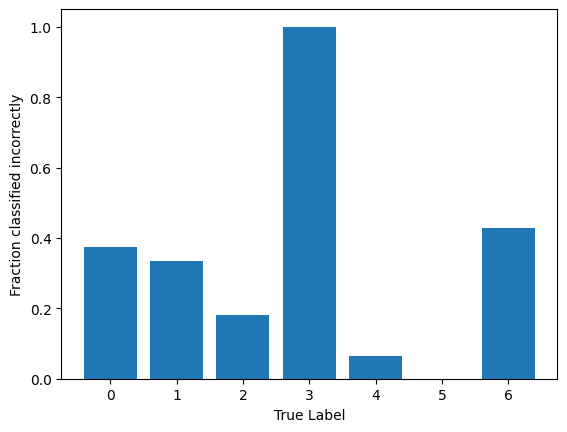

In [27]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Conclusion:
It seems our model has maximum number of incorrect predictions for Dermatofibroma which has code 3, then second most missclassified type is Melanoma code 6 then Benign Keratosis-like Lesions code 2 where as Vascular_lesions code 5 has least misclassified type.

The validation accuracy(around 0.8438) being higher than the test accuracy(around 0.6848) indicates that the model performs better on the validation set compared to the unseen test set. This might suggest that the model has overfitted to the validation data.

Despite achieving high training accuracy (around 0.8531), the significant drop in accuracy on the test data suggests that the model may not generalize well to new, unseen data.

## ResNet

### Importing Essential Libraries
In this step we imported the necessary libraries for the project, including pandas for data manipulation, numpy for numerical operations, matplotlib for data visualization, and torch for deep learning. We also imported the ResNet34 model from torchvision.models and the ImageDataLoaders class from the fastai library for data loading and augmentation.

In [145]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path
import torch
from torchvision.models import ResNet34_Weights
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing and Augmentation
File structure

| File                           | Path                          |
| ------------------------------ | ----------------------------- |
| training and validation images | ./data/train/images/          |
| training labels                | ./data/train/train_labels.csv |
| valitation labels              | ./data/train/valid_labels.csv |
| testing images                 | ./data/test/images/           |
| testing labels                 | ./data/test/labels.csv        |
| pre-trained models             | ./data/train/models/          |

In this step we prepared the data for training, validation, and testing. We created DataFrames for the training and validation sets by reading the labels from the CSV files and matching them with the image filenames. We also created a DataFrame for the testing set by reading the labels from the CSV file and matching them with the image filenames. We then applied data augmentation and normalization using the fastai library to preprocess the image data. Finally, we created a DataLoader object to load the data for training, validation, and testing.

In [146]:
# set paths
train_path = Path('data/train')
test_path = Path('data/test')

# set a dictionary for labels
label_list = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_dict = {label: idx for idx, label in enumerate(label_list)}

In [147]:
# setup DataFrames for validation set and training set
def prepare_df(df, dataset_type):
    # training set
    if dataset_type == 0:
        df['fname'] = df['image']+'.jpg'
        df['label'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)
        df['label'] = df['label'].map(label_dict)
        df['is_valid'] = False
        return df[['fname', 'label', 'is_valid']]
    # validation set
    elif dataset_type == 1:
        df['fname'] = df['image']+'.jpg'
        df['label'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)
        df['label'] = df['label'].map(label_dict)
        df['is_valid'] = True
        return df[['fname', 'label', 'is_valid']]
    # testing set
    elif dataset_type == 2:
        df['fname'] = df['image'].apply(lambda x: test_path/'images'/f'{x}.jpg')
        df['label'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)
        df['label'] = df['label'].map(label_dict)
        return df[['fname', 'label']]

In [148]:
# load csv files
train_df = pd.read_csv(train_path/'train_labels.csv')
valid_df = pd.read_csv(train_path/'valid_labels.csv')
test_df = pd.read_csv(test_path/'labels.csv')
# print(train_df.head())
# print(valid_df.head())
# print(test_df.head())

train_df = prepare_df(train_df, 0).copy()
valid_df = prepare_df(valid_df, 1).copy()
df = pd.concat([train_df, valid_df])

test_df = prepare_df(test_df, 2).copy()
# print(test_df)

In [149]:
# Define data augmentation
item_tfms = Resize(150, 75)
batch_tfms = aug_transforms(
    do_flip=True,       # horizontal flip
    flip_vert=False,    # No vertical flip
    max_rotate=10.0,    # Rotate randomly 10 degrees
    max_zoom=1.1,       # Randomly zoom in by 10%
    max_lighting=0.0,   # No lighting transformation
    max_warp=0.0,       # No deformation
    xtra_tfms=[
        RandomResizedCrop(size=(150,75), min_scale=0.9),  # Random cropping and scaling
        FlipItem(p=0.5),  # horizontal flip
        Brightness(max_lighting=0.2, p=0.75),  # Brightness adjustment
        Warp(magnitude=0.2, p=0.2)  # Image distortion
    ],
    pad_mode='zeros'  # padding with zeros
)

### Training
In this step, we defined a data loader using the ImageDataLoaders class from the fastai library. We used the DataFrame objects created earlier to load the image data and labels for the training and validation sets. We applied the data augmentation and normalization transformations to preprocess the image data. We then defined a ResNet34 model using the vision_learner function from the fastai library and set the metrics to accuracy. We used the lr_find method to find the optimal learning rate for training the model. We then trained the model using the fine_tune method with the optimal learning rate, maximum number of epochs, and early stopping callback. We saved the trained model using the export method.

In [150]:
# define a data loder
dls = ImageDataLoaders.from_df(
    df,
    path=train_path,
    folder='images',
    valid_col='is_valid',
    label_col='label',
    seed=42,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=32
)

In [151]:
# check if GPU is available
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

1
Using device: cuda


True


SuggestedLRs(valley=0.0012022644514217973)

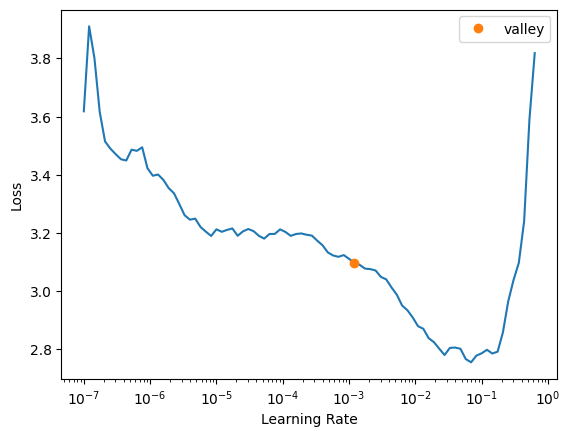

In [155]:
# Transfer learning using the pre-trained model ResNet34
learn = vision_learner(dls, resnet34, metrics=accuracy)
# Move training process to GPU
learn.model = learn.model.to('cuda')
# Check if GPU is in use
print(next(learn.model.parameters()).is_cuda)  # should return True

# find the optimal learning rate
learn.lr_find()

In [156]:
# use the optimal learning rate
optimal_lr = 1e-3
# maximum epoch number
max_epoch = 40
# patience before early stopping
patience = 10

# define the early stopping callback function
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=patience)
# define the save model callback function
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')
# save the training log
csv_logger = CSVLogger(fname='training_log.csv')
# start training
learn.fine_tune(max_epoch, base_lr=optimal_lr, cbs=[early_stopping_cb, save_model_cb, csv_logger])

# show a batch
dls.show_batch()

Better model found at epoch 0 with valid_loss value: 0.934734582901001.


Better model found at epoch 0 with valid_loss value: 0.7086160182952881.
Better model found at epoch 1 with valid_loss value: 0.6150192022323608.
Better model found at epoch 2 with valid_loss value: 0.5730305910110474.
Better model found at epoch 3 with valid_loss value: 0.5300535559654236.
Better model found at epoch 4 with valid_loss value: 0.4951852262020111.
Better model found at epoch 6 with valid_loss value: 0.4630088210105896.
Better model found at epoch 8 with valid_loss value: 0.40691637992858887.
No improvement since epoch 8: early stopping


In [157]:
# save the learner
learn.export('trained_model.pkl')

### Testing and evaluation
In this step, we loaded the trained model and created a DataLoader object for the test set using the test_dl method. We used the get_preds method to make predictions on the test set and calculated the accuracy, F1 score, and confusion matrix to evaluate the model's performance.

In [158]:
# load the pretrained model
# learn_loaded = load_learner('./data/train/models/trained_model.pkl')
# test_dl = learn_loaded.dls.test_dl(test_df['fname'])
# preds, targs  = learn_loaded.get_preds(dl=test_dl)
# pred_labels = preds.argmax(dim=1)


learn_test = vision_learner(dls, resnet34, metrics=accuracy, weights=ResNet34_Weights.IMAGENET1K_V1)
learn_test.load('best_model')

test_dl = learn_test.dls.test_dl(test_df['fname'])

preds, targs  = learn_test.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)

Test Accuracy: 0.7751
F1 Score: 0.7642


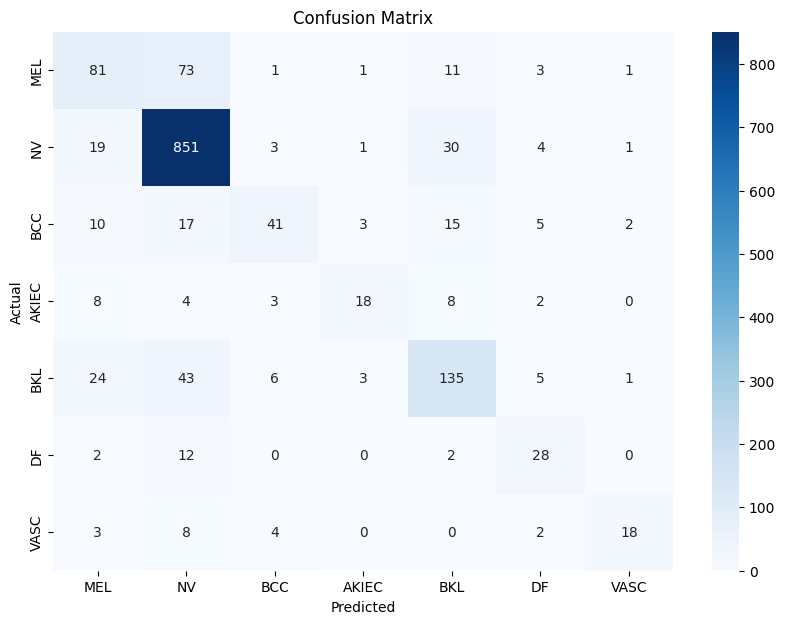

In [159]:
# print the accuracy, f1-score and confusion matrix
accuracy = accuracy_score(test_df['label'], pred_labels)
f1 = f1_score(test_df['label'], pred_labels, average='weighted')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(test_df['label'], pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Conclusion
The ResNet34 model achieved an accuracy of 0.7751 and an F1 score of 0.7642 on the test set. The confusion matrix shows that the model performed well on some classes, such as melanocytic nevi (NV) and basal cell carcinoma (BCC), but struggled with others, such as actinic keratoses (AKIEC) and vascular lesions (VASC). The results indicate that the model has room for improvement, and further fine-tuning or training with additional data may help improve its performance.

## VGG

### data frame
 It defines a function create_dataframe that reads image filenames from a directory and matches them with labels from a CSV file, organizing the data into a dictionary. This dictionary is then converted into a DataFrame. The function is applied to create DataFrames for training, validation, and test sets, with samples from each set printed to verify the data. This prepares the image data and labels for further machine learning tasks.Finally, we will confirm that the output of some dataframe contents is correct.

In [1]:
import os
import pandas as pd

def create_dataframe(image_dir, groundtruth_file):

    groundtruth_df = pd.read_csv(groundtruth_file)
    
    image_files = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    
    data = {'image': [], 'MEL': [], 'NV': [], 'BCC': [], 'AKIEC': [], 'BKL': [], 'DF': [], 'VASC': []}
    
    for image_file in image_files:

        label_row = groundtruth_df.loc[groundtruth_df['image'] == image_file]
        if not label_row.empty:
            data['image'].append(image_file + '.jpg') 
            for label in ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']:
                data[label].append(label_row[label].values[0])
    
    df = pd.DataFrame(data)
    return df


train_image_dir = 'ISIC2018_Task3_Training_Input'
train_groundtruth_file = 'ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
train_df = create_dataframe(train_image_dir, train_groundtruth_file)


valid_image_dir = 'ISIC2018_Task3_Validation_Input'
valid_groundtruth_file = 'ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'
valid_df = create_dataframe(valid_image_dir, valid_groundtruth_file)


test_image_dir = 'ISIC2018_Task3_Test_Input'
test_groundtruth_file = 'ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv'
test_df = create_dataframe(test_image_dir, test_groundtruth_file)

print("Training DataFrame Sample:")
print(train_df.head(10))

print("\nTesting DataFrame Sample:")
print(test_df.head(10))

print("Training DataFrame Sample:")
print(valid_df.head(10))

Training DataFrame Sample:
              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0
5  ISIC_0024311.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
6  ISIC_0024312.jpg  0.0  0.0  0.0    0.0  1.0  0.0   0.0
7  ISIC_0024313.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0
8  ISIC_0024314.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
9  ISIC_0024315.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0

Testing DataFrame Sample:
              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034524.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0034525.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0034526.jpg  0.0  0.0  0.0    0.0  1.0  0.0   0.0
3  ISIC_0034527.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0034528.jp

The SkinLesionDataset class inherits from Dataset and loads images and their corresponding labels from a given DataFrame and directory. Data augmentation and normalization are applied using torchvision transforms. The create_datasets function sets up dataloaders for training, validation, and test datasets, with a specified batch size. After creating the dataloaders, the code prints their lengths and visualizes a batch of training images using a helper function imshow that reverses normalization for display purposes.In order to maintain the consistency of the comparison results, the data augmentation content used is consistent. The sample size is proportionally reduced to 100, 75. Compared with the original version of 255, 255, there is a significant improvement.

Train loader length: 626
Validation loader length: 13
Test loader length: 95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


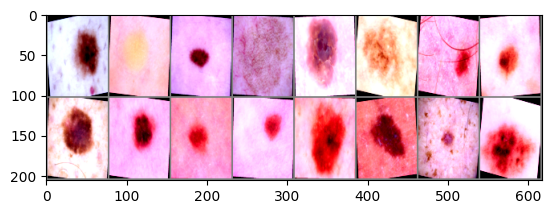

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.dataframe.iloc[idx, 1:].values.astype('float')
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels


image_size = (100, 75)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(10),  # Randomly rotate the image
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
        transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),  # Randomly crop the image
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),  # Resize the image
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ]),
}

def create_datasets(train_df, test_df, valid_df, train_image_dir, test_image_dir, valid_image_dir, batch_size):
    train_dataset = SkinLesionDataset(dataframe=train_df, image_dir=train_image_dir, transform=data_transforms['train'])
    val_dataset = SkinLesionDataset(dataframe=valid_df, image_dir=valid_image_dir, transform=data_transforms['val'])
    test_dataset = SkinLesionDataset(dataframe=test_df, image_dir=test_image_dir, transform=data_transforms['val'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

batch_size = 16

train_loader, val_loader, test_loader = create_datasets(train_df, test_df, valid_df, train_image_dir, test_image_dir, valid_image_dir, batch_size)

print(f'Train loader length: {len(train_loader)}')
print(f'Validation loader length: {len(val_loader)}')
print(f'Test loader length: {len(test_loader)}')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))


In [3]:
import torch
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


PyTorch version: 2.4.0+cu124
cuda


**Feature Extraction Layers**: Retains the original VGG19 feature extraction part, which includes multiple convolutional and pooling layers to extract image features.

**Average Pooling Layer**: Uses the VGG19 average pooling layer to compress features.

**Custom Classifier**: Implements a custom classifier with three fully connected layers. Two of these layers have ReLU activation functions and Dropout regularization, and the final layer outputs the classification results.Given the uneven distribution of the dataset size and labels, I added a fully connected layer activation function and a regularized Dropout layer to further distinguish complex content data issues.

The cross entropy loss function (nn.CrossEntropyLoss) and the Adam optimizer (optim.Adam) are used, and the learning rate is set to 0.0001.

In each epoch, the model is set to training mode, and the training loop performs forward propagation, loss calculation, backward propagation, and optimization steps to update model parameters.


**Training performance**: The model performs well on the training data, and the training accuracy gradually increases from 0.6957 to 0.9000, indicating that the model can effectively learn the characteristics of the training data.

**Verification performance**: The verification accuracy gradually increased from 0.7513 to 0.8394, but in the later period (after the 10th epoch), it showed a certain fluctuation and downward trend, and the verification loss was also increasing, indicating that the generalization ability of the model on the verification data has declined.

**Overfitting**: The model performs well on the training set, but the performance on the validation set begins to fluctuate, the validation loss increases, and the validation accuracy no longer improves, indicating that the model may overfit the training data.

**Possible improvements to the model**:
1. Introduce early stopping method, monitor validation loss, and stop training when validation loss no longer decreases to prevent overfitting 
2. Further enhance data diversity and improve the generalization ability of the model by adding data enhancement operations (such as color jitter, random cropping, etc.) Appropriately reducing the complexity of the model, such as reducing the number of nodes or layers in the fully connected layer, can help prevent overfitting.


Epoch 1/20, Loss: 0.8548, Train Accuracy: 0.6957
Validation Loss: 0.6627, Validation Accuracy: 0.7513
Epoch 2/20, Loss: 0.6991, Train Accuracy: 0.7465
Validation Loss: 0.5259, Validation Accuracy: 0.8187
Epoch 3/20, Loss: 0.6355, Train Accuracy: 0.7671
Validation Loss: 0.6213, Validation Accuracy: 0.7927
Epoch 4/20, Loss: 0.5870, Train Accuracy: 0.7880
Validation Loss: 0.4460, Validation Accuracy: 0.8394
Epoch 5/20, Loss: 0.5530, Train Accuracy: 0.7991
Validation Loss: 0.4840, Validation Accuracy: 0.8238
Epoch 6/20, Loss: 0.5066, Train Accuracy: 0.8181
Validation Loss: 0.4270, Validation Accuracy: 0.8497
Epoch 7/20, Loss: 0.4845, Train Accuracy: 0.8235
Validation Loss: 0.4980, Validation Accuracy: 0.8394
Epoch 8/20, Loss: 0.4671, Train Accuracy: 0.8330
Validation Loss: 0.4932, Validation Accuracy: 0.8290
Epoch 9/20, Loss: 0.4268, Train Accuracy: 0.8496
Validation Loss: 0.4948, Validation Accuracy: 0.8497
Epoch 10/20, Loss: 0.4076, Train Accuracy: 0.8548
Validation Loss: 0.6058, Validat

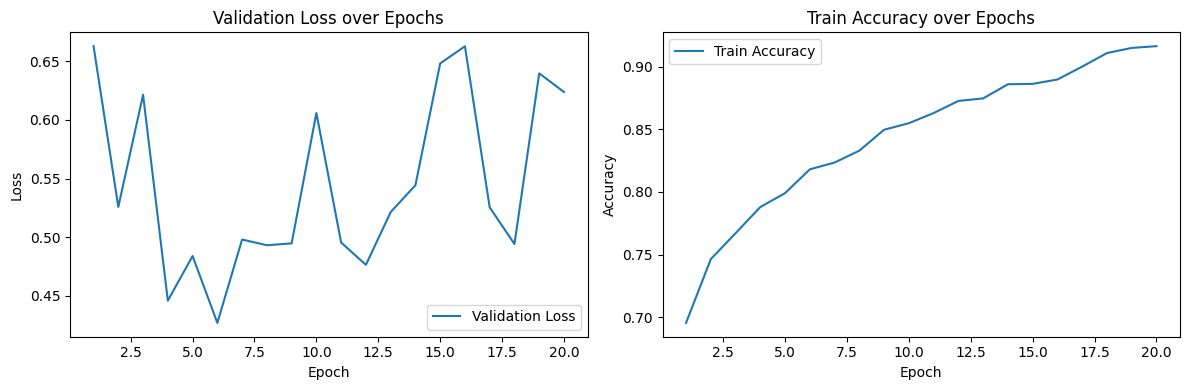

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import  models
import matplotlib.pyplot as plt

class CustomVGG19(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG19, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = train_df.shape[1] - 1 
model = CustomVGG19(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

# For plotting
train_accuracies = []
val_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, 1)
        correct_train += torch.sum(preds == torch.argmax(labels, 1)).item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    model.eval()
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)
            correct_val += torch.sum(preds == torch.argmax(labels, 1)).item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training complete')

model.eval()
test_loss = 0.0
corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, 1)
        corrects += torch.sum(preds == torch.argmax(labels, 1)).item()

test_loss /= len(test_loader.dataset)
test_accuracy = corrects / len(test_loader.dataset)
test_accuracies.append(test_accuracy)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print('Training complete')

model.to('cpu')
torch.save(model.state_dict(), 'VGG-isic2018.pth')

# Plotting the metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Read the saved image and generate a confusion matrix

C:\Users\forsa\AppData\Local\Temp\ipykernel_5168\384971079.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.9172, Test Accuracy: 0.7414


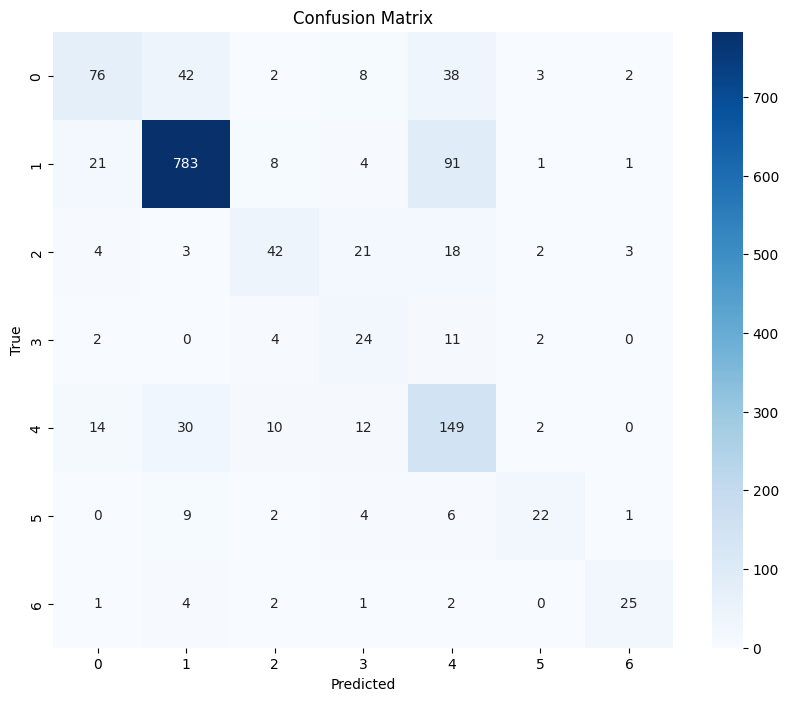

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim


class CustomVGG19(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG19, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = 7

model_path = 'VGG-isic2018.pth'  
model = CustomVGG19(num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((100, 75)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

test_loss = 0.0
corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, 1)
        corrects += torch.sum(preds == torch.argmax(labels, 1)).item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(torch.argmax(labels, 1).cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = corrects / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

cm = confusion_matrix(all_labels, all_preds)
# 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 
cm = np.array([
    [ 76,  42,   2,   8,  38,   3,   2],
    [ 21, 783,   8,   4,  91,   1,   1],
    [  4,   3,  42,  21,  18,   2,   3],
    [  2,   0,   4,  24,  11,   2,   0],
    [ 14,  30,  10,  12, 149,   2,   0],
    [  0,   9,   2,   4,   6,  22,   1],
    [  1,   4,   2,   1,   2,   0,  25]
])

true_labels = []
pred_labels = []

for i in range(len(cm)):
    for j in range(len(cm)):
        true_labels.extend([i] * cm[i, j])
        pred_labels.extend([j] * cm[i, j])

precision = precision_score(true_labels, pred_labels, average=None)
recall = recall_score(true_labels, pred_labels, average=None)
f1 = f1_score(true_labels, pred_labels, average=None)
weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')

for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'  Precision: {precision[i]:.4f}')
    print(f'  Recall:    {recall[i]:.4f}')
    print(f'  F1 Score:  {f1[i]:.4f}')

print(f'Weighted F1 Score: {weighted_f1:.4f}')


Class 0:
  Precision: 0.6441
  Recall:    0.4444
  F1 Score:  0.5260
Class 1:
  Precision: 0.8990
  Recall:    0.8614
  F1 Score:  0.8798
Class 2:
  Precision: 0.6000
  Recall:    0.4516
  F1 Score:  0.5153
Class 3:
  Precision: 0.3243
  Recall:    0.5581
  F1 Score:  0.4103
Class 4:
  Precision: 0.4730
  Recall:    0.6866
  F1 Score:  0.5602
Class 5:
  Precision: 0.6875
  Recall:    0.5000
  F1 Score:  0.5789
Class 6:
  Precision: 0.7812
  Recall:    0.7143
  F1 Score:  0.7463
Weighted F1 Score: 0.7463


## DenseNet

### Data Sources and Exploratory Analysis of Data:

In this project, the dataset from ISIC 2018(MSK Dataset: (c) Anonymous; https://arxiv.org/abs/1710.05006; https://arxiv.org/abs/1902.03368). In training set, there are a total of 10015 skin lesion images from seven skin diseases- Melanoma (1113), Melanocytic nevus (6705), Basal cell carcinoma (514), Actinic keratosis (327), Benign keratosis (1099), Dermatofibroma (115) and Vascular (142). The validation dataset consists of 193 images. There are a lot pictures, so we need model learn more features from data, so freeze the convolutional layers of the pretrained model at the initial stage and add custom top layer.

In [1]:
# Import necessary libraries
import os
from glob import glob

import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

### Data processing:
All of teammates of our team use the same method to process data. Seven classes and load data which download from the website.
And resize the images to 100 * 75

In [2]:
# Load the Dataset.
train_data_dir = './ISIC2018_Task3_Training_Input'
train_groundtruth = './ISIC2018_Task3_Training_GroundTruth.csv'
val_data_dir = './ISIC2018_Task3_Validation_Input'
val_groundtruth = './ISIC2018_Task3_Validation_GroundTruth.csv'
test_data_dir = './ISIC2018_Task3_Test_Input'
test_groundtruth = './ISIC2018_Task3_Test_GroundTruth.csv'

# Get all training, validation, and test image paths and store them in dictionaries, 
# with the key being the image name and the value being the image path
train_paths = glob(os.path.join(train_data_dir, '*.jpg'))
train_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in train_paths}
val_paths = glob(os.path.join(val_data_dir, '*.jpg'))
val_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in val_paths}
test_paths = glob(os.path.join(test_data_dir, '*.jpg'))
test_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in test_paths}

# Define a dictionary to map lesion type abbreviations to full names
lesion_type_dict = {
    'NV': 'Melanocytic_nevi',
    'MEL': 'melanoma',
    'BKL': 'Benign_keratosis-like_lesions',
    'BCC': 'Basal_cell_carcinoma',
    'AKIEC': 'Actinic_keratoses',
    'VASC': 'Vascular_lesions',
    'DF': 'Dermatofibroma',
}

# Define a list to map labels
label_mapping = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [3]:
# Load ground truth data
train_df = pd.read_csv(train_groundtruth)
val_df = pd.read_csv(val_groundtruth)
test_df = pd.read_csv(test_groundtruth)

In [4]:
# Convert categories to one-hot encoding
def classify_disease(row):
    if row['MEL'] == 1.0:
        return 'MEL'
    elif row['NV'] == 1.0:
        return 'NV'
    elif row['BCC'] == 1.0:
        return 'BCC'
    elif row['AKIEC'] == 1.0:
        return 'AKIEC'
    elif row['BKL'] == 1.0:
        return 'BKL'
    elif row['DF'] == 1.0:
        return 'DF'
    elif row['VASC'] == 1.0:
        return 'VASC'
    else:
        return 'Unknown'

# Apply the function to convert labels to disease names
train_df['dx'] = train_df.apply(classify_disease, axis=1)
val_df['dx'] = val_df.apply(classify_disease, axis=1)
test_df['dx'] = test_df.apply(classify_disease, axis=1)

# Add image paths to the DataFrame
train_df['path'] = train_df['image'].map(train_path_dict.get)
train_df['cell_type'] = train_df['dx'].map(lesion_type_dict.get)
train_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
train_df["cell_type_idx"] = pd.Categorical(train_df["cell_type"]).codes

# Drop original one-hot encoded columns
val_df['path'] = val_df['image'].map(val_path_dict.get)
val_df['cell_type'] = val_df['dx'].map(lesion_type_dict.get)
val_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
val_df["cell_type_idx"] = pd.Categorical(val_df["cell_type"]).codes

# Perform the same operations for the validation dataset
test_df['path'] = test_df['image'].map(test_path_dict.get)
test_df['cell_type'] = test_df['dx'].map(lesion_type_dict.get)
test_df.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1, inplace=True)
test_df["cell_type_idx"] = pd.Categorical(test_df["cell_type"]).codes

In [5]:
# Resize images to a consistent shape
train_df['image_size'] = train_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
val_df['image_size'] = val_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
test_df['image_size'] = test_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
train_df.head()

image   dx                                              path  \
0  ISIC_0024306   NV  ./ISIC2018_Task3_Training_Input\ISIC_0024306.jpg   
1  ISIC_0024307   NV  ./ISIC2018_Task3_Training_Input\ISIC_0024307.jpg   
2  ISIC_0024308   NV  ./ISIC2018_Task3_Training_Input\ISIC_0024308.jpg   
3  ISIC_0024309   NV  ./ISIC2018_Task3_Training_Input\ISIC_0024309.jpg   
4  ISIC_0024310  MEL  ./ISIC2018_Task3_Training_Input\ISIC_0024310.jpg   

          cell_type  cell_type_idx  \
0  Melanocytic_nevi              4   
1  Melanocytic_nevi              4   
2  Melanocytic_nevi              4   
3  Melanocytic_nevi              4   
4          melanoma              6   

                                          image_size  
0  [[[228, 131, 133], [229, 131, 137], [231, 125,...  
1  [[[216, 121, 133], [217, 121, 136], [218, 126,...  
2  [[[246, 173, 181], [246, 171, 176], [246, 170,...  
3  [[[206, 117, 133], [210, 121, 136], [211, 120,...  
4  [[[72, 33, 37], [70, 32, 38], [69, 31, 38], [6...

In [6]:
# Convert the resized image data to NumPy arrays
x_train = np.asarray(train_df['image_size'].tolist())
x_val = np.asarray(val_df['image_size'].tolist())
x_test = np.asarray(test_df['image_size'].tolist())

# Calculate the mean and standard deviation
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_val_mean = np.mean(x_val)
x_val_std = np.std(x_val)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_val_mean) / x_val_std
x_test = (x_test - x_test_mean) / x_test_std

In [7]:
# Convert the labels to one-hot encoded format
num_classes = 7
y_train = to_categorical(train_df['cell_type_idx'], num_classes=num_classes)
y_val = to_categorical(val_df['cell_type_idx'], num_classes=num_classes)
y_test = to_categorical(test_df['cell_type_idx'], num_classes=num_classes)

### Model:
DenseNet(Densely Connected Convolutional Networks) is a deep learning model. DenseNet improves model performance by introducing dense connections to enhance information flow and gradient propagation. It is a pre-trained model.
The basic building block of DenseNet is CNN (Convolutional Neural Network).
I am using DenseNet201 which is a member of the DenseNet family and contains 201 layers.
Using a pre-trained model can significantly reduce both training time and resource consumption. That’s why I chose it.

### Method:
Freeze the convolutional layers of the pre-trained model at the initial stage then get the 'relu' layer, output of the pre-trained model from pre-trained model and add custom top layers to learn more features from the data.
Implementing an early stopping function to control validation loss.
Using ImageDataGenerator from Keras to process data increase the diversity of training data.

In [9]:
# Load the pre-trained DenseNet201 model
# Set input_shape to (75, 100, 3) to match the resized images (height: 75, width: 100, channels: 3)
pre_trained_model = DenseNet201(input_shape=(75, 100, 3), include_top=False, weights="imagenet")

In [10]:
# Iterate over all the layers in the pre-trained model
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False # freeze
    
print(len(pre_trained_model.layers))

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [11]:
# Get the 'relu' layer from the pre-trained model
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)

# Get the output of the pre-trained model
last_output = pre_trained_model.output

last layer output shape: (None, 2, 3, 1920)


In [12]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 81, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 38, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 38, 50, 64)   256         ['conv1/conv[0][0]']         

In [14]:
# Set up data augmentation for the training data
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)

In [15]:
batch_size = 32
epochs = 3

# Train the model using the data generators
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_val, y_val),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size), 
                              validation_steps=(x_val.shape[0] // batch_size))

Epoch 1/3
312/312 [==============================] - 22s 40ms/step - loss: 1.4636 - accuracy: 0.6345 - val_loss: 0.8603 - val_accuracy: 0.6875
Epoch 2/3
312/312 [==============================] - 11s 34ms/step - loss: 0.8765 - accuracy: 0.6974 - val_loss: 0.7564 - val_accuracy: 0.7135
Epoch 3/3
312/312 [==============================] - 11s 34ms/step - loss: 0.7917 - accuracy: 0.7168 - val_loss: 0.7329 - val_accuracy: 0.7135


In [16]:
# Iterate over all the layers in the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = True #  unfreeze

In [17]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0, amsgrad=False)

# Compile the model with the categorical crossentropy loss function and the Adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [19]:
# Set up the ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
# Set up the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

In [20]:
batch_size = 32
epochs = 20

# Train the model using the data generators
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_val, y_val),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/20
312/312 [==============================] - 43s 102ms/step - loss: 0.9462 - acc: 0.6767 - val_loss: 0.6350 - val_acc: 0.7604 - lr: 1.0000e-04
Epoch 2/20
312/312 [==============================] - 30s 96ms/step - loss: 0.7022 - acc: 0.7448 - val_loss: 0.5318 - val_acc: 0.8021 - lr: 1.0000e-04
Epoch 3/20
312/312 [==============================] - 30s 98ms/step - loss: 0.6056 - acc: 0.7772 - val_loss: 0.4830 - val_acc: 0.8021 - lr: 1.0000e-04
Epoch 4/20
312/312 [==============================] - 30s 97ms/step - loss: 0.5437 - acc: 0.7987 - val_loss: 0.4730 - val_acc: 0.8281 - lr: 1.0000e-04
Epoch 5/20
312/312 [==============================] - 29s 94ms/step - loss: 0.4851 - acc: 0.8224 - val_loss: 0.4714 - val_acc: 0.8125 - lr: 1.0000e-04
Epoch 6/20
312/312 [==============================] - 30s 96ms/step - loss: 0.4521 - acc: 0.8351 - val_loss: 0.4725 - val_acc: 0.7760 - lr: 1.0000e-04
Epoch 7/20
312/312 [==============================] - ETA: 0s - loss: 0.4079 - acc: 0.8468
Ep

### Result(accuracy):
After training, the accuracy results are as follows:
- Validation: accuracy = 0.813471 ; loss_v = 0.469321
- Test: accuracy = 0.753968 ; loss = 0.702043

The validation set accuracy is high, test set accuracy is relatively low, showing model has limited generalization ability. 

In [21]:
# Validation accuracy
loss_val, acc_val = model.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 1s 39ms/step - loss: 0.4693 - acc: 0.8135
Validation: accuracy = 0.813471  ;  loss_v = 0.469321


In [26]:
# Test accuracy
loss_test, acc_test = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

48/48 [==============================] - 2s 34ms/step - loss: 0.7020 - acc: 0.7540
Test: accuracy = 0.753968  ;  loss = 0.702043


In [27]:
# save model
model.save("DenseNetFull_model.h5")

### Result(Training process):
Initially, the model was trained directly, resulting in high training accuracy but constant validation accuracy and increasing validation loss around the 8th to 9th epoch, indicating overfitting. To address this, the convolutional layers of the pre-trained DenseNet201 were frozen, and additional top layers were added to improve feature learning. An early stopping function was also implemented to control validation loss.

Text(0.5, 1.0, 'Training and validation loss')

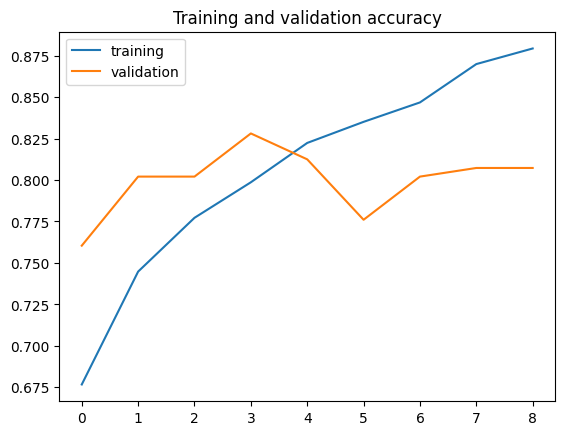

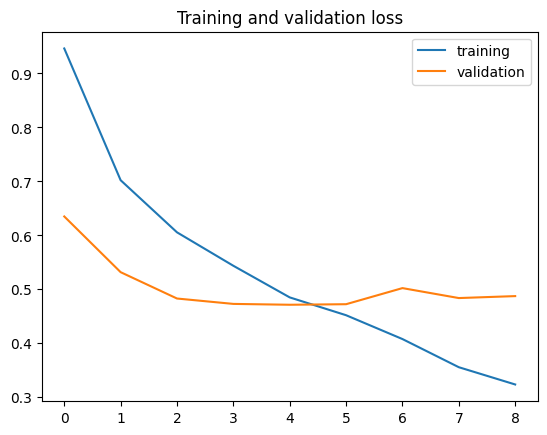

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

### Result(confusion matrix and classification report):
From confusion matrix and classification report, the number of correct classifications for class 4 (Melanocytic nevi) and F1 score are significantly higher than other classes. Means model is accurate prediction of this class. 
The overall weighted average precision, recall, and F1 score are all around 0.75 indicating that the overall performance of the model is at a medium level.

48/48 [==============================] - 8s 30ms/step


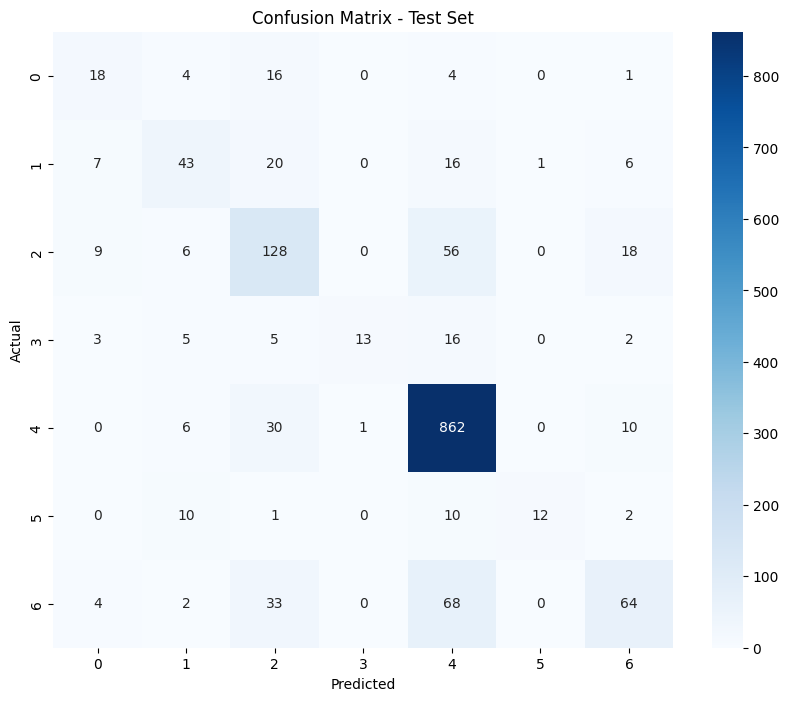

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.44      0.42      0.43        43
     Class 1       0.57      0.46      0.51        93
     Class 2       0.55      0.59      0.57       217
     Class 3       0.93      0.30      0.45        44
     Class 4       0.84      0.95      0.89       909
     Class 5       0.92      0.34      0.50        35
     Class 6       0.62      0.37      0.47       171

    accuracy                           0.75      1512
   macro avg       0.69      0.49      0.54      1512
weighted avg       0.75      0.75      0.74      1512



In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model from a file
model = load_model('DenseNetFull_model.h5')
y_test_classes = np.argmax(y_test, axis=1)

# Predict test set
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# confusion matrix
cm_test = confusion_matrix(y_test_classes, y_pred_test_classes)

# Draw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Classification Report
report = classification_report(y_test_classes, y_pred_test_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
print("Classification Report:")
print(report)

### Discussion:
#### Strengths:
High Validation Accuracy: Achieving a validation accuracy of 0.81 demonstrates that the model has a good understanding of the validation data, suggesting effective feature extraction and learning from the dataset.

Class 4 Prediction: The model excels in predicting class 4 (Melanocytic nevi), with higher accuracy and F1 scores for this class. This indicates that the model has successfully learned the features associated with this specific class.

#### Weaknesses:
Limited Generalization exist, the lower test accuracy (0.75) compared to validation accuracy indicates that the model has limited generalization ability. This discrepancy suggests that the model's performance drops when exposed to entirely new data.

Imbalanced Performance Across Classes: The model's significantly better performance on class 4 highlights an imbalance in its ability to predict different classes. This imbalance can be detrimental in applications where accurate classification across all classes is crucial. And still exist overfiting problem

#### Limitations:
Despite adding top layers, the model's ability to learn distinctive features from the data might still be insufficient, as indicated by the medium-level overall performance.

#### Future Work:
Addressing the class imbalance issue, either through resampling techniques or by applying class weights during training, can help in achieving more balanced performance across all classes. Implementing data augmentation techniques to reduce overfitting and improving generalization.

### Conclusion:
In conclusion, while the DenseNet201 model shows promising results with high validation accuracy and effective prediction for certain classes, addressing overfitting, improving generalization, and ensuring balanced performance are essential for enhancing the overall system performance.